### Universidade Federal do Tocantins
#### Curso: Ciência da Computação
#### Disciplina: Redes Neurais e Aprendizado Profundo (Deep Learning)
#### Professor: Dr. Marcelo Lisboa Rocha
#### Acadêmico: Antonio André Bacelos Chagas

##### Construção de um modelo CNN (com Transfer Learning - EfficientNetB0) para detecção de tumores cerebrais a partir de imagens de ressonância magnética (MRI) utilizando TensorFlow e Keras.

##### Data set utilizado: [Kaggle Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, models
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path

# Configurar diretórios (Mantendo sua lógica original)
possible_base_dirs = [
    Path("/content/drive/MyDrive/Colab Notebooks/trabalho_final"),
    Path.cwd(),
]

base_dir = None
for candidate in possible_base_dirs:
    candidate = candidate.expanduser().resolve()
    if (candidate / "Training").is_dir():
        base_dir = candidate
        break

if base_dir:
    train_dir = base_dir / "Training"
    test_dir = base_dir / "Testing"
    print(f"Diretórios definidos: {train_dir}")

    # Diretório para salvar modelos
    checkpoints_dir = os.path.join(base_dir, "checkpoints_modelo")
    os.makedirs(checkpoints_dir, exist_ok=True)
    modelo_final_salvo_path = os.path.join(checkpoints_dir, "brain_tumor_classifier_optimized.keras")

Diretórios definidos: /content/drive/MyDrive/Colab Notebooks/trabalho_final/Training


In [5]:
# --- ALTERAÇÃO 1: Resolução Nativa do EfficientNet ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
COLOR_MODE = 'rgb'

print("Carregando datasets com resolução 224x224...")

train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=True
)

validation_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=True
)

test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=False
)

class_names = train_dataset.class_names
print(f"Classes: {class_names}")

# Otimização de performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Carregando datasets com resolução 224x224...
Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
def create_optimized_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape + (3,), name="input_layer")

    # Data Augmentation (Leve para não distorcer características médicas)
    # Nota: Não usamos Rescaling aqui porque o EfficientNetB0 do Keras faz isso internamente
    x = layers.RandomRotation(0.05)(inputs)
    x = layers.RandomZoom(0.1)(x)
    x = layers.RandomFlip("horizontal")(x)

    # Carregar modelo base (Transfer Learning)
    # include_top=False remove a classificação original (1000 classes do ImageNet)
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)

    # FASE 1: Congelar o modelo base completamente
    base_model.trainable = False

    # Reconstruir o classificador (Head)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.3)(x) # Dropout para evitar overfitting
    x = layers.Dense(512, activation="relu")(x) # Camada densa robusta
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = models.Model(inputs, outputs, name="Brain_Tumor_EfficientNet")
    return model

# Criar o modelo
model = create_optimized_model(IMG_SIZE, num_classes=len(class_names))
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Brain_Tumor_EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ random_zoom[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha

 Total params: 4,714,663 (17.99 MB)

 Trainable params: 661,508 (2.52 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

In [7]:
# --- FASE 1: Treinar apenas o classificador (Feature Extraction) ---
print("\n=== FASE 1: Treinando o classificador (Base congelada) ===")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
]

history_1 = model.fit(
    train_dataset,
    epochs=12, # Poucas épocas para ajustar o topo
    validation_data=validation_dataset,
    callbacks=callbacks_phase1
)

# --- FASE 2: Fine-Tuning (Descongelar e refinar) ---
print("\n=== FASE 2: Fine-Tuning (Ajuste fino da rede completa) ===")

# Descongelar o modelo base para permitir que ele aprenda características do cérebro
# Acessamos a camada do EfficientNet (geralmente é a layer[3] ou [4] devido ao augmentation)
for layer in model.layers:
    if isinstance(layer, keras.Model): # Encontra o backbone EfficientNet
        layer.trainable = True

        # Dica Pro: Manter BatchNormalization congelado no Fine-Tuning melhora estabilidade
        for sub_layer in layer.layers:
            if isinstance(sub_layer, layers.BatchNormalization):
                sub_layer.trainable = False

# IMPORTANTE: Recompilar com Learning Rate MUITO BAIXA (1e-5)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=modelo_final_salvo_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Treinar por mais épocas, começando de onde parou
history_2 = model.fit(
    train_dataset,
    epochs=35,
    initial_epoch=history_1.epoch[-1],
    validation_data=validation_dataset,
    callbacks=callbacks_phase2
)


=== FASE 1: Treinando o classificador (Base congelada) ===
Epoch 1/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 936s 4s/step - accuracy: 0.7466 - loss: 0.8351 - val_accuracy: 0.8074 - val_loss: 0.4829
Epoch 2/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.8563 - loss: 0.4248 - val_accuracy: 0.8476 - val_loss: 0.3979
Epoch 3/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.8784 - loss: 0.3253 - val_accuracy: 0.8695 - val_loss: 0.3666
Epoch 4/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.8997 - loss: 0.2785 - val_accuracy: 0.9063 - val_loss: 0.2795
Epoch 5/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.9076 - loss: 0.2465 - val_accuracy: 0.8923 - val_loss: 0.2923
Epoch 6/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.9163 - loss: 0.2164 - val_accuracy: 0.8905 - val_loss: 0.3282
Epoch 7/12
143/143 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.9085 - loss: 0.2397 - val_accuracy: 0.9089 - val_loss: 0.2586
Epoch 8/12
143/143 ━━━━━━━━━━━━━━━━━━

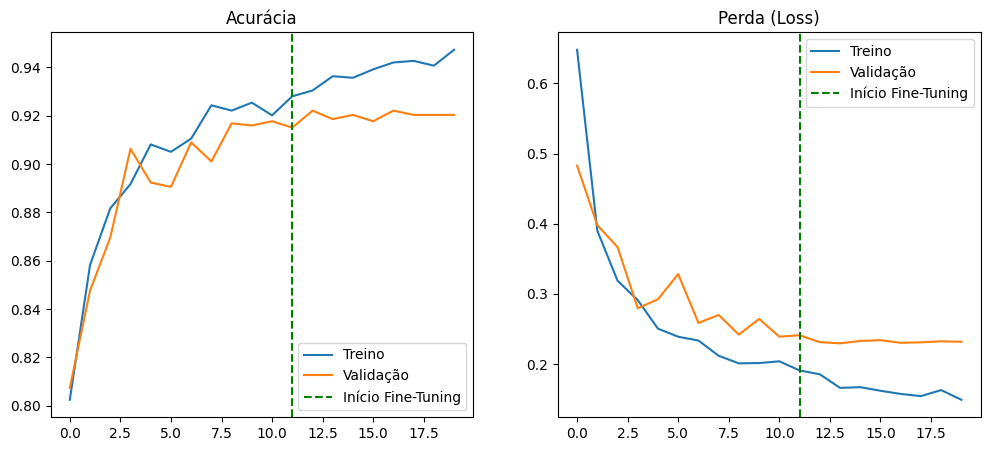


=== AVALIAÇÃO FINAL NO TEST SET ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8701 - loss: 0.3407
              precision    recall  f1-score   support

      glioma       0.92      0.84      0.88       300
  meningioma       0.85      0.79      0.82       306
     notumor       0.97      0.98      0.98       405
   pituitary       0.87      1.00      0.93       300

    accuracy                           0.91      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



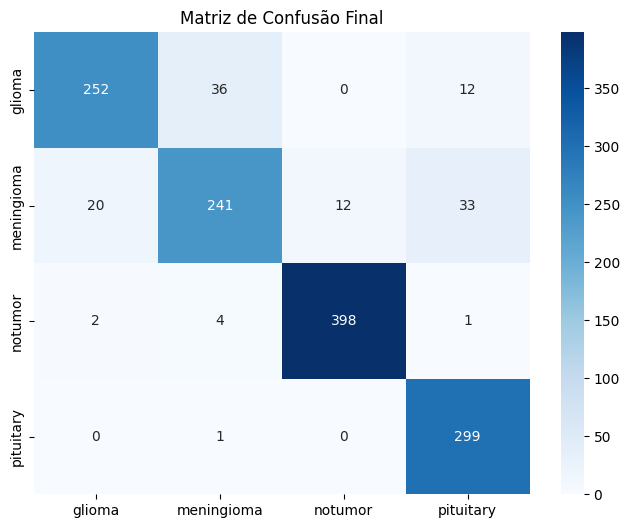

In [8]:
# Unir históricos para plotagem
def plot_full_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Treino')
    plt.plot(val_acc, label='Validação')
    plt.axvline(x=len(h1.history['accuracy'])-1, color='green', linestyle='--', label='Início Fine-Tuning')
    plt.title('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Treino')
    plt.plot(val_loss, label='Validação')
    plt.axvline(x=len(h1.history['loss'])-1, color='green', linestyle='--', label='Início Fine-Tuning')
    plt.title('Perda (Loss)')
    plt.legend()
    plt.show()

plot_full_history(history_1, history_2)

# Avaliação Final no Teste
print("\n=== AVALIAÇÃO FINAL NO TEST SET ===")
# Carregar o melhor modelo salvo pelo Checkpoint da Fase 2
model.load_weights(modelo_final_salvo_path)
model.evaluate(test_dataset)

# Matriz de Confusão e Report
y_pred = []
y_true = []
for img, label in test_dataset:
    pred = model.predict(img, verbose=0)
    y_pred.extend(np.argmax(pred, axis=1))
    y_true.extend(np.argmax(label.numpy(), axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Matriz de Confusão Final")
plt.show()